In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import keras
from keras import layers

In [38]:
# Path to the dataset
DATA_DIR = 'data/train/'

In [39]:
# Load the dataset
images = []
labels = []

# Loop through each folder in the dataset
for folder in os.listdir(DATA_DIR):
    folder_path = os.path.join(DATA_DIR, folder)
    if os.path.isdir(folder_path):
        # Extract the character label from the folder name (e.g., Sample001 -> '001')
        label = folder[6:]  # Assuming 'SampleXXX' format

        # Loop through each image in the folder
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)

            # Read the image in grayscale
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (28, 28))

            # Append image and label to the lists
            images.append(img)
            labels.append(label)
            
# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

In [40]:
# Reshape the images to add a channel dimension (for grayscale images)
images = images.reshape(-1, 28, 28, 1)

# Normalize pixel values to the range [0, 1]
images = images / 255.0

In [41]:
images[0].reshape(28, 28)

array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.    

In [42]:
# Encode the labels using LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

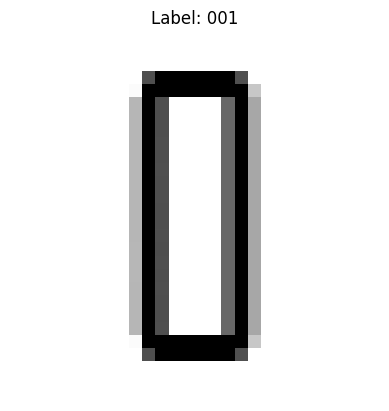

In [43]:
# Select an image to visualize (e.g., the first image in the dataset)
image_index = 0

# Extract the corresponding image from the dataset (use squeeze() to remove the extra channel dimension)
image_to_show = images[image_index].squeeze()

# Display the image
plt.imshow(image_to_show, cmap='gray')
plt.title(f"Label: {label_encoder.inverse_transform([encoded_labels[image_index]])[0]}")
plt.axis('off')  # Turn off axis
plt.show()

In [49]:
# Define the model
model_architecture = [
    # First Convolutional Layer
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Layer
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output to feed into Dense layers
    layers.Flatten(),

    # Fully Connected Layer with Dropout
    layers.Dense(128, activation='relu', input_dim=57600),
    layers.Dropout(0.5),

    # Output Layer with Softmax activation for multi-class classification
    layers.Dense(62, activation='softmax', input_dim=57600)
]

# Display the model architecture
keras.Sequential(model_architecture).summary()

C:\Users\kingb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\kingb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 62)             │         7,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,742 (905.24 KB)

 Trainable params: 231,742 (905.24 KB)

 Non-trainable params: 0 (0.00 B)

## Cross Validation

In [46]:
n_splits = 4
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

In [52]:
def train_model(X_train, y_train, X_val, y_val):
    # Define the model
    model = keras.Sequential(model_architecture)

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train the model
    return model.fit(X_train, y_train,
                        epochs=10,
                        batch_size=64,
                        validation_data=(X_val, y_val),
                        verbose=10)

In [53]:
val_accuracies = []

# Loop through each split
for i, (train_index, val_index) in enumerate(kf.split(images)):
    print(f"------------ Fold {i + 1} / {n_splits} ------------")
    X_train, X_val = images[train_index], images[val_index]
    y_train, y_val = encoded_labels[train_index], encoded_labels[val_index]

    history = train_model(X_train, y_train, X_val, y_val)

    val_accuracies.append(history.history['val_accuracy'][-1])
    print(f"Accuracy: {history.history['val_accuracy'][-1]}")

------------ Fold 1 / 4 ------------
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Accuracy: 0.9425261616706848
------------ Fold 2 / 4 ------------
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Accuracy: 0.9429022669792175
------------ Fold 3 / 4 ------------
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Accuracy: 0.949371874332428
------------ Fold 4 / 4 ------------
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Accuracy: 0.951403021812439


In [54]:
average_val_accuracy = np.mean(val_accuracies)
print(f'Average validation accuracy: {average_val_accuracy}')

Average validation accuracy: 0.9465508311986923
